### Imports

In [13]:
from __future__ import print_function
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import time
import h5py
from pathlib import Path
import os

from art.attacks import CarliniL2Method, CarliniLInfMethod
from art.classifiers import PyTorchClassifier
from art.utils import load_cifar10

%matplotlib inline
%config InlineBackend.figure_format='retina'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Dataset

In [14]:
# Read CIFAR10 dataset
(x_train, y_train), (x_test, y_test), min_, max_ = load_cifar10()

x_train = np.swapaxes(x_train, 1, 3).astype(np.float32)
x_test = np.swapaxes(x_test, 1, 3).astype(np.float32)

train_dataset = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
train_dataloader = DataLoader(train_dataset, batch_size=128)

test_dataset = TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))
test_dataloader = DataLoader(test_dataset, batch_size=1000)
test_dataloader_single = DataLoader(test_dataset, batch_size=1)

In [15]:
class_to_idx = {'airplane': 0,
                 'automobile': 1,
                 'bird': 2,
                 'cat': 3,
                 'deer': 4,
                 'dog': 5,
                 'frog': 6,
                 'horse': 7,
                 'ship': 8,
                 'truck': 9}

idx_to_class = dict([(value, key) for key, value in class_to_idx.items()]) 

### Inputs

In [16]:
path = Path("C:/Users/Matach/Documents/Imperial College London/FYP/saved_models/CIFAR10/FGSM/vanilla/")
file = "model_03.pth"
pretrained_model = os.path.join(path, file)
use_cuda = True

## Model

In [5]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.dropout = nn.Dropout(p=0.1)
        self.fc1 = nn.Linear(4096, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
        
    activations = []             # list to save the activations of the penultimate layer while training on forwardDetect
    mask = torch.zeros(1, 512)   # mask for the forwardMask function for pruning
    

    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
    
    def forwardDetect(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        self.activations.append(x)
        x = self.fc3(x)
        return x
    
    def forwardMask(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))*self.mask
        x = self.fc3(x)
        return x

    
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
    
# Initialize the model.
model = Model().to(device)

# Load pre-trained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
print(model.eval())

# Load loss and optimiser
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Make a classifier wrapper!
classifier = PyTorchClassifier(
    model=model,
    clip_values=(min_, max_),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(3, 32, 32),
    nb_classes=10,
)

# Test model
predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {} %".format(accuracy * 100))

Model(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Dropout2d(p=0.05, inplace=False)
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dropout): Dropout(p=0.1, inplace=F

## MASK model

In [19]:
class MaskModel(nn.Module):
    def __init__(self):
        super(MaskModel, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.dropout = nn.Dropout(p=0.1)
        self.fc1 = nn.Linear(4096, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
        
    activations = []             # list to save the activations of the penultimate layer while training on forwardDetect
    mask = torch.ones(1, 512)   # mask for the forwardMask function for pruning
    
    
    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))*self.mask.to(device)
        x = self.fc3(x)
        return x

    
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
    
# Initialize the model.
model_mask = MaskModel().to(device)

# Load pre-trained model
model_mask.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
print(model_mask.eval())

# Load loss and optimiser
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Make a classifier wrapper!
mask_classifier = PyTorchClassifier(
    model=model_mask,
    clip_values=(min_, max_),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(3, 32, 32),
    nb_classes=10,
)

# Test model
predictions = mask_classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {} %".format(accuracy * 100))

CUDA Available:  True
MaskModel(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Dropout2d(p=0.05, inplace=False)
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dropout)

## Pruning FC2

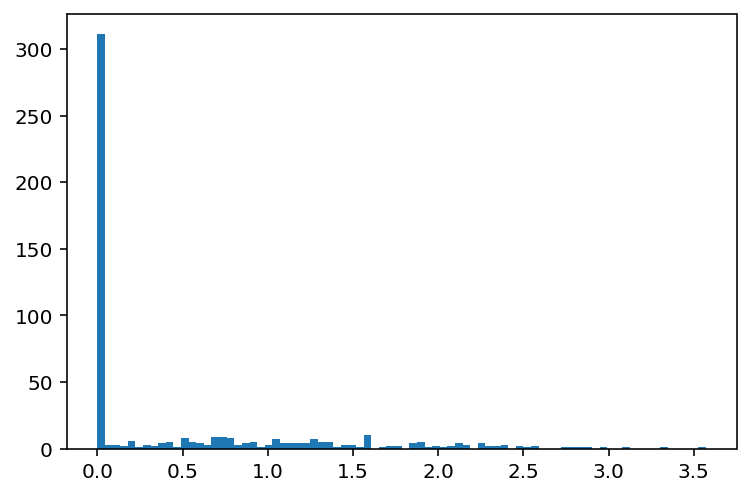

In [6]:
### Get activations in the layer previous to the output layer ###

model.eval() 
with torch.no_grad():
    for data, target in test_dataloader_single:
        output = model.forwardDetect(data.to(device))
activations = model.activations
n = len(activations)
element0 = activations.pop()
act = torch.zeros(n,element0.size(0),element0.size(1))
act[0,:,:] = element0

for e in range(n-1):
    elementX = activations.pop()
    act[e+1,:,:] = elementX

mean_activations = torch.mean(act,dim=[0,1])
ma = mean_activations.numpy()
plt.hist(ma,80)
plt.show()

In [7]:
# save different masks for different percentages

acc = []
masks = dict()

for percentage in range(10):
    s_ma, idx_ma = torch.sort(mean_activations)
    m = torch.ones(mean_activations.size()).to(device)
    nn = mean_activations.size(0)
    
    ind_r = round((percentage/10)*nn)
    m[idx_ma[:ind_r]] = 0.0
    n1 = m.sum()
    model.mask = m
    masks[percentage/10] = model.mask
    
    
# evaluate with the new masks

for pg, mask in masks.items():
    model.mask = mask
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_dataloader_single:
            output = model.forwardMask(data.to(device))
            pred = output.data.max(1, keepdim=True)[1].to("cpu")
            target = np.argmax(target, axis=1)
            correct += pred.eq(target.data.view_as(pred)).sum()
        acc_test = float(correct.numpy() / len(test_dataloader_single.dataset))
        acc.append(acc_test)

    print("Pruned {}  Accuracy: {} %".format(pg, 100*acc_test))

Pruned 0.0  Accuracy: 79.61 %
Pruned 0.1  Accuracy: 79.61 %
Pruned 0.2  Accuracy: 79.61 %
Pruned 0.3  Accuracy: 79.61 %
Pruned 0.4  Accuracy: 79.61 %
Pruned 0.5  Accuracy: 79.61 %
Pruned 0.6  Accuracy: 79.64 %
Pruned 0.7  Accuracy: 79.53 %
Pruned 0.8  Accuracy: 79.31 %
Pruned 0.9  Accuracy: 78.86999999999999 %


## Carlini

In [20]:
# Generate adversarial test examples
def CarliniL2(classifier, x_test, init_const):
    start = time.time()
    attack = CarliniL2Method(classifier=classifier,
                            confidence=0.0,
                            targeted=False,
                            learning_rate=0.01,
                            binary_search_steps=2,
                            initial_const=init_const,
                            batch_size=64)
    x_test_adv = attack.generate(x=x_test)
    end = time.time()
    
    return x_test_adv

def CarliniLInf(classifier, x_test, epsilon):
    start = time.time()
    attack = CarliniLInfMethod(classifier=classifier, 
                              confidence=0.0,
                              targeted=False, 
                              learning_rate=0.01,
                              eps=epsilon, 
                              batch_size=128)
    x_test_adv = attack.generate(x=x_test)
    end = time.time()
    
    return x_test_adv

# Calculate distance 
def L2distance(x_test, x_test_adv):
    dist = 0
    samples_changed = 0
    for test, adv_test in zip(x_test, x_test_adv):
        l2 = np.linalg.norm(test-adv_test)
        dist += l2
        samples_changed = samples_changed + 1 if l2>0 else samples_changed
    dist /= samples_changed
    return dist

### L2

In [23]:
carlini_prune = dict()
constants = [0.01, 0.05, 0.1, 0.5, 1.0]
n = 1000
# Run test for each c and mask PG 
for pg, mask in masks.items():
    print('\n Pruned {}'.format(pg))
    accuracies = []
    distances = []
    results = dict()
    
    model_mask.mask = mask
    
    for init in constants:
        x_test_adv = CarliniL2(mask_classifier, x_test[:n], init_const=init)
        predictions = mask_classifier.predict(x_test_adv)
        acc = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test[:n], axis=1)) / n
        accuracies.append(acc)
        distances.append(L2distance(x_test[:n], x_test_adv))
        
        print('c:', init, ' Accuracy:', acc, ' Distance:', round(distances[-1], 3))

    results['accuracies'] = accuracies
    results['distances'] = distances
    results['constants'] = constants
    carlini_prune[pg] = results


 Pruned 0.0
c: 0.01  Accuracy: 0.26  Distance: 0.132
c: 0.05  Accuracy: 0.12  Distance: 0.203
c: 0.1  Accuracy: 0.111  Distance: 0.237
c: 0.5  Accuracy: 0.109  Distance: 0.354
c: 1.0  Accuracy: 0.108  Distance: 0.403

 Pruned 0.1
c: 0.01  Accuracy: 0.26  Distance: 0.132
c: 0.05  Accuracy: 0.12  Distance: 0.203
c: 0.1  Accuracy: 0.111  Distance: 0.237
c: 0.5  Accuracy: 0.109  Distance: 0.354
c: 1.0  Accuracy: 0.108  Distance: 0.403

 Pruned 0.2
c: 0.01  Accuracy: 0.26  Distance: 0.132
c: 0.05  Accuracy: 0.12  Distance: 0.203
c: 0.1  Accuracy: 0.111  Distance: 0.237
c: 0.5  Accuracy: 0.109  Distance: 0.354
c: 1.0  Accuracy: 0.108  Distance: 0.403

 Pruned 0.3
c: 0.01  Accuracy: 0.26  Distance: 0.132
c: 0.05  Accuracy: 0.12  Distance: 0.203
c: 0.1  Accuracy: 0.111  Distance: 0.237
c: 0.5  Accuracy: 0.109  Distance: 0.354
c: 1.0  Accuracy: 0.108  Distance: 0.403

 Pruned 0.4
c: 0.01  Accuracy: 0.259  Distance: 0.133
c: 0.05  Accuracy: 0.12  Distance: 0.202
c: 0.1  Accuracy: 0.111  Distanc

### LInf

In [34]:
carlini_inf_prune = dict()
epsilons = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006]
n = 1000
# Run test for each epsilon and mask PG 
for pg, mask in masks.items():
    print('\n Pruned {}'.format(pg))
    accuracies = []
    results = dict()
    
    model_mask.mask = mask
    
    for eps in epsilons:
        x_test_adv = CarliniLInf(mask_classifier, x_test[:n], epsilon=eps)
        predictions = mask_classifier.predict(x_test_adv)
        acc = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test[:n], axis=1)) / n
        accuracies.append(acc)
        
        print('eps:', eps, ' Accuracy:', acc)

    results['accuracies'] = accuracies
    results['epsilons'] = epsilons
    carlini_inf_prune[pg] = results


 Pruned 0.0
eps: 0.001  Accuracy: 0.753
eps: 0.002  Accuracy: 0.682
eps: 0.003  Accuracy: 0.597
eps: 0.004  Accuracy: 0.515
eps: 0.005  Accuracy: 0.446
eps: 0.006  Accuracy: 0.379

 Pruned 0.1
eps: 0.001  Accuracy: 0.753
eps: 0.002  Accuracy: 0.682
eps: 0.003  Accuracy: 0.597
eps: 0.004  Accuracy: 0.515
eps: 0.005  Accuracy: 0.446
eps: 0.006  Accuracy: 0.379

 Pruned 0.2
eps: 0.001  Accuracy: 0.753
eps: 0.002  Accuracy: 0.682
eps: 0.003  Accuracy: 0.597
eps: 0.004  Accuracy: 0.515
eps: 0.005  Accuracy: 0.446
eps: 0.006  Accuracy: 0.379

 Pruned 0.3
eps: 0.001  Accuracy: 0.753
eps: 0.002  Accuracy: 0.682
eps: 0.003  Accuracy: 0.597
eps: 0.004  Accuracy: 0.515
eps: 0.005  Accuracy: 0.446
eps: 0.006  Accuracy: 0.379

 Pruned 0.4
eps: 0.001  Accuracy: 0.753
eps: 0.002  Accuracy: 0.682
eps: 0.003  Accuracy: 0.597
eps: 0.004  Accuracy: 0.515
eps: 0.005  Accuracy: 0.446
eps: 0.006  Accuracy: 0.379

 Pruned 0.5
eps: 0.001  Accuracy: 0.754
eps: 0.002  Accuracy: 0.682
eps: 0.003  Accuracy: 0.59

## Results

### L2

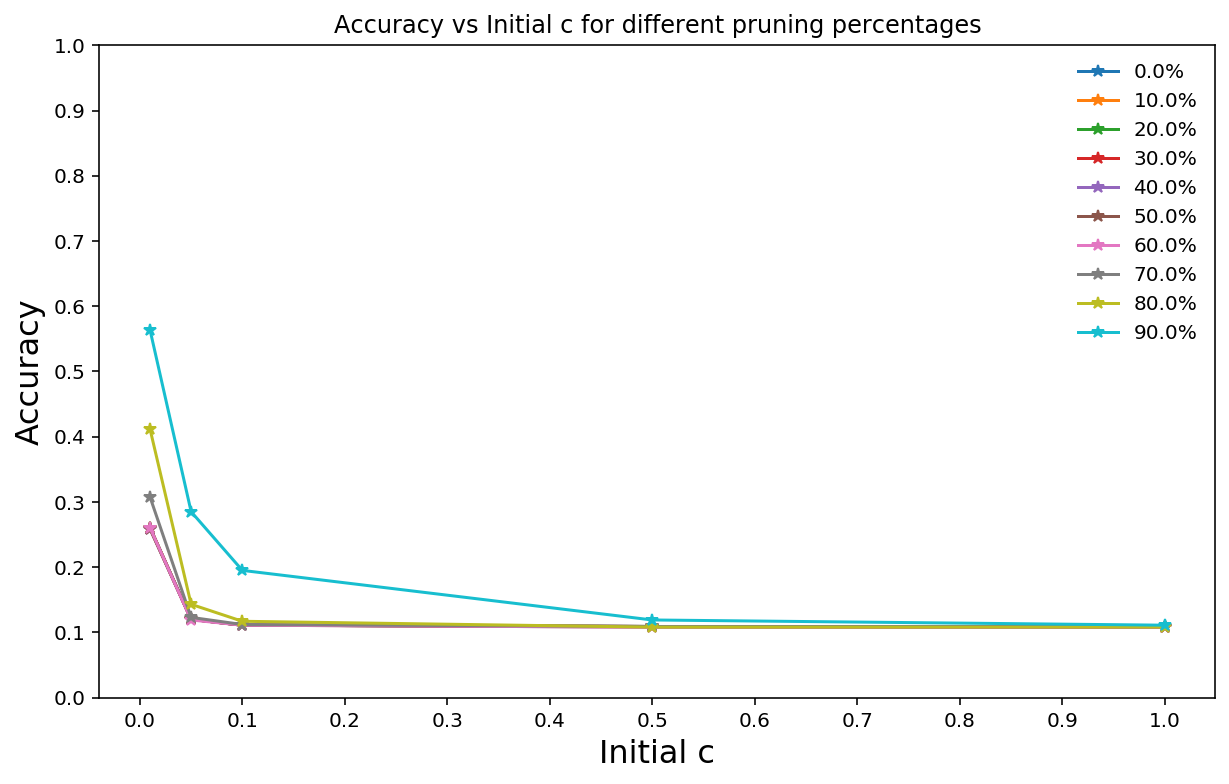

In [39]:
# plot the pruned accuracies vs initial c

plt.figure(figsize=(10,6))

for pg, results in carlini_prune.items():
    plt.plot(results['constants'], results['accuracies'], "*-", label=str(pg*100)+'%')

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 1.1, step=0.1))
plt.title("Accuracy vs Initial c for different pruning percentages")
plt.xlabel("Initial c",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.legend(loc='upper right', frameon=False)
plt.show()

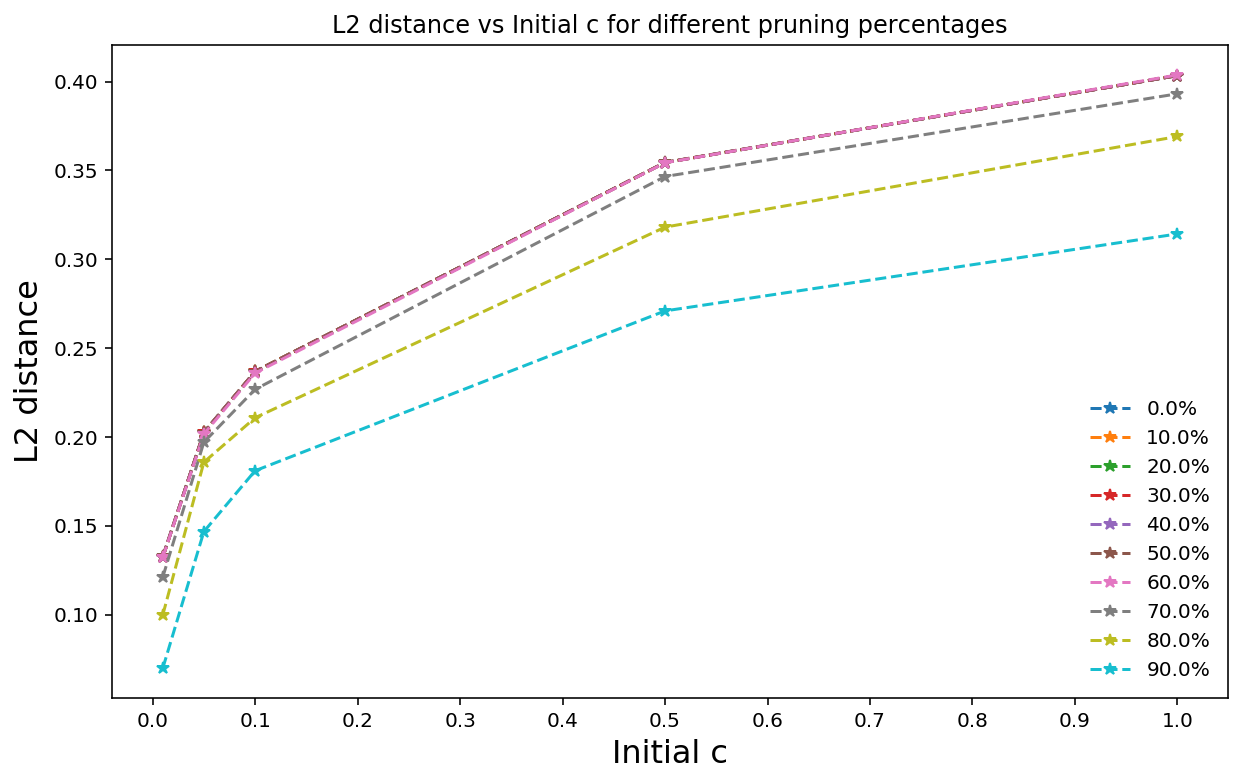

In [31]:
# plot the pruned accuracies vs initial c

plt.figure(figsize=(10,6))

for pg, results in carlini_prune.items():
    plt.plot(results['constants'], results['distances'], "*--", label=str(pg*100)+'%')

plt.xticks(np.arange(0, 1.1, step=0.1))
plt.title("L2 distance vs Initial c for different pruning percentages")
plt.xlabel("Initial c",fontsize=16)
plt.ylabel("L2 distance",fontsize=16)
plt.legend(loc='lower right', frameon=False)
plt.show()

### LInf

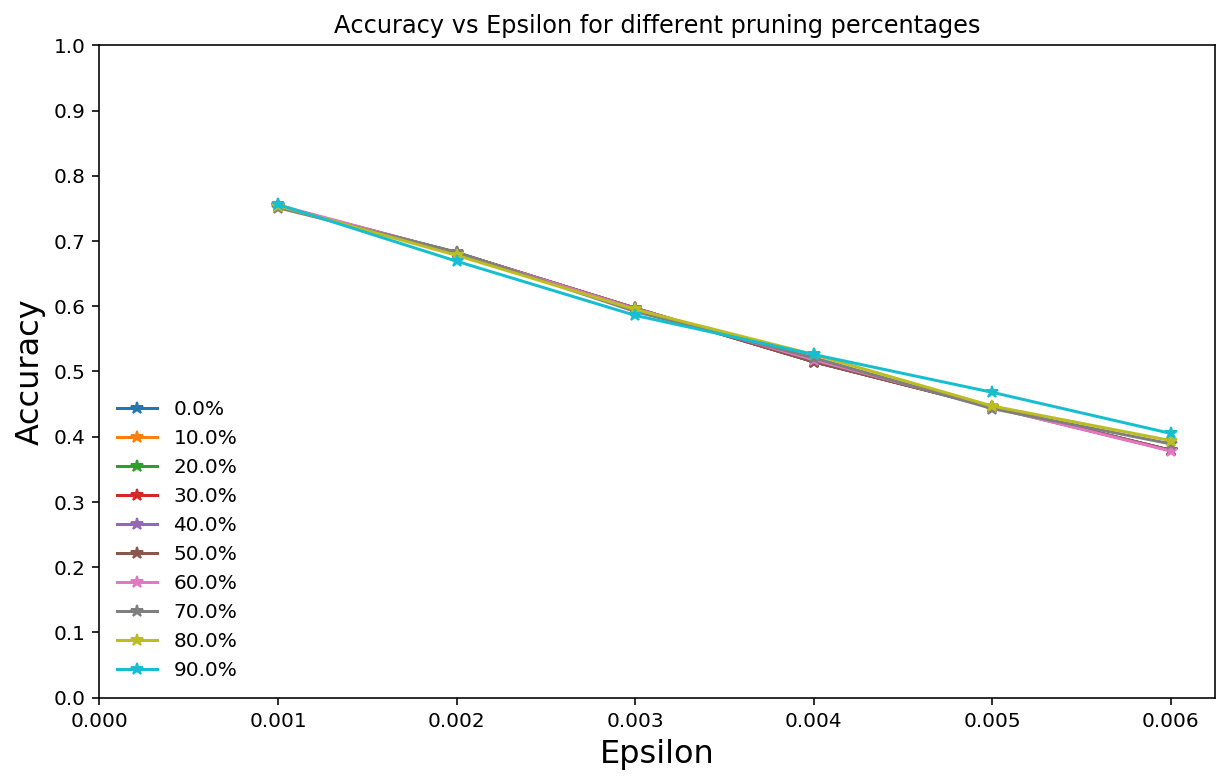

In [36]:
# plot the pruned accuracies vs epsilon 

plt.figure(figsize=(10,6))

for pg, results in carlini_inf_prune.items():
    plt.plot(results['epsilons'], results['accuracies'], "*-", label=str(pg*100)+'%')

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 0.0061, step=0.001))
plt.title("Accuracy vs Epsilon for different pruning percentages")
plt.xlabel("Epsilon",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.legend(loc='lower left', frameon=False)
plt.show()